In [2]:
import sys
sys.path.append('../src/training-on-CM2.6')

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
from matplotlib.colors import LinearSegmentedColormap
import cmocean

from helpers.cm26 import DatasetCM26, read_datasets
from helpers.selectors import *
from helpers.plot_helpers import *

%load_ext autoreload
%autoreload 3

In [2]:
ds = read_datasets(['test'], [4,9,12,15], subfilter='subfilter', FGR=3)
ds2d = ds['test-4'].select2d()

Reading from folder /vast/pp2681/CM26_datasets/ocean3d/subfilter/FGR3/factor-4
Reading from folder /vast/pp2681/CM26_datasets/ocean3d/subfilter/FGR3/factor-9
Reading from folder /vast/pp2681/CM26_datasets/ocean3d/subfilter/FGR3/factor-12
Reading from folder /vast/pp2681/CM26_datasets/ocean3d/subfilter/FGR3/factor-15


In [ ]:
import gc
for factor in [15,12,9,4]:
    dataset = ds[f'test-{factor}']
    fun = dataset.state.JansenHeld
    %time skill = dataset.predict_ZB(fun=fun).SGS_skill()
    skill.to_netcdf(f'/scratch/pp2681/mom6/CM26_ML_models/ocean3d/subfilter-large/FGR3/JansenHeld/skill-test/factor-{factor}.nc')
    del skill
    gc.collect()

CPU times: user 1min 55s, sys: 13.9 s, total: 2min 9s
Wall time: 1min 53s
CPU times: user 2min 21s, sys: 21.3 s, total: 2min 42s
Wall time: 2min 17s
CPU times: user 3min 19s, sys: 40.7 s, total: 4min
Wall time: 3min 15s


In [ ]:
import gc
for factor in [15,12,9,4]:
    dataset = ds[f'test-{factor}']
    fun = dataset.state.ZB20
    %time skill = dataset.predict_ZB(fun=fun, ZB_scaling=0.5).SGS_skill()
    skill.to_netcdf(f'/scratch/pp2681/mom6/CM26_ML_models/ocean3d/subfilter-large/FGR3/ZB20/ZB-SCALING-0.5/skill-test/factor-{factor}.nc')
    del skill
    gc.collect()

# Read offline skill of subgrid models

In [2]:
def read_skill(exp='subfilter/FGR3/EXP1', factors=[4,9,12,15], base_path='/scratch/pp2681/mom6/CM26_ML_models/ocean3d/'):
    ds = {}
    for factor in factors:
        data = xr.open_dataset(f'{base_path}/{exp}/skill-test/factor-{factor}.nc', chunks={'zl':1})
        data['zl'] = -data['zl']
        ds[factor] = data
        
    return ds

In [3]:
jansenheld = read_skill('subfilter-large/FGR3/JansenHeld')

In [4]:
zb20 = read_skill('subfilter-large/FGR3/ZB20/ZB-SCALING-0.5')

In [39]:
# Default ANN tested in online simulations
ann_default = read_skill('subfilter/FGR3/EXP1')
ann_32_32 = read_skill('subfilter/FGR3/EXP-32-32/repeat')
ann_1x1 = read_skill('subfilter/FGR3/EXP-32-32/1x1')

# Spectral properties

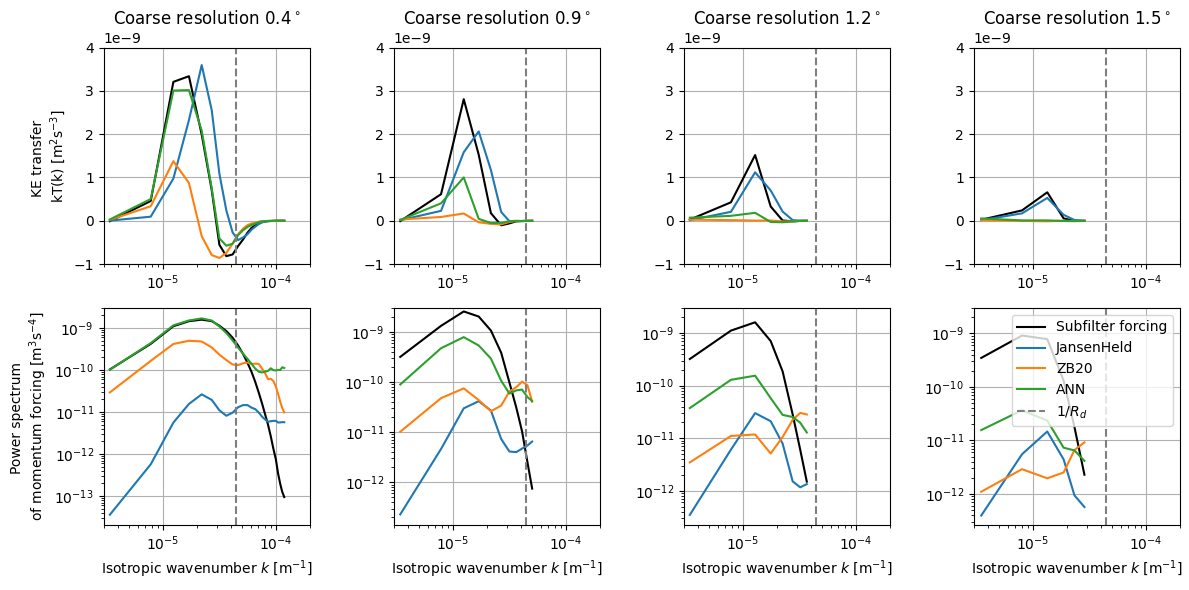

In [10]:
plt.figure(figsize=(12,6))

for column, factor, resolution in zip([0,1,2,3],[4,9,12,15],['$0.4^\circ$', '$0.9^\circ$', '$1.2^\circ$', '$1.5^\circ$']):
    plt.subplot(2,4,column+1)
    jansenheld[factor].transfer_NA.mean('time').isel(zl=0).plot(color='k', label='Subfilter forcing')
    jansenheld[factor].transfer_ZB_NA.mean('time').isel(zl=0).plot(label='JansenHeld')
    zb20[factor].transfer_ZB_NA.mean('time').isel(zl=0).plot(label='ZB20')
    ann_default[factor].transfer_ZB_NA.mean('time').isel(zl=0).plot(label='ANN')
    plt.xscale('log')
    plt.title(f'Coarse resolution {resolution}')
    plt.tight_layout()
    plt.xlabel('')
    if column==0:
        plt.ylabel('KE transfer \nkT(k) [m$^2$s$^{-3}$]')
    else:
        plt.ylabel('')
    plt.xlim([3e-6, 2e-4])
    plt.ylim([-1e-9, 4e-9])
    plt.grid()
    plt.axvline(x=1/(22.6e+3), color='tab:gray', ls='--')

    plt.subplot(2,4,column+5)
    jansenheld[factor].power_NA.mean('time').isel(zl=0).plot(color='k', label='Subfilter forcing')
    jansenheld[factor].power_ZB_NA.mean('time').isel(zl=0).plot(label='JansenHeld')
    zb20[factor].power_ZB_NA.mean('time').isel(zl=0).plot(label='ZB20')
    ann_default[factor].power_ZB_NA.mean('time').isel(zl=0).plot(label='ANN')
    plt.xscale('log')
    plt.yscale('log')
    plt.title('')
    plt.tight_layout()
    plt.xlabel('Isotropic wavenumber $k$ [$\mathrm{m}^{-1}$]')
    if column==0:
        plt.ylabel('Power spectrum \nof momentum forcing [m$^3$s$^{-4}$]')
    else:
        plt.ylabel('')
    plt.xlim([3e-6, 2e-4])
    plt.ylim([-0.1e-9, 3e-9])
    plt.grid()
    plt.axvline(x=1/(22.6e+3), color='tab:gray', ls='--')

plt.plot(np.nan, np.nan, color='tab:gray', ls='--', label='$1/R_d$')
plt.legend()

# Offline skill

In [41]:
import cmocean
import matplotlib.patches as patches
def plot_metric(exp=None, metric='R2_away',vmin=-1,vmax=1,cmap=cmocean.cm.balance,err_format="%.2f", show_numbers=True, title=False, xlabel=False, ylabel=False, add_yellow_rectangle=True, add_orange_rectangle=True, add_cyan_rectangle=True):
    data = xr.concat([exp[factor][metric] for factor in [4,9,12,15]], dim='factor')
    im = data.drop_vars(['zl']).plot(x='factor', y='zl',cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False)

    if show_numbers:
    # Add text annotations
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                plt.text(i, j, err_format % float(data[i,j]),
                        ha='center', va='center', color='white', fontsize=10)

    if add_yellow_rectangle:
        rectangle = patches.Rectangle(
                                        (1 - 0.45, 0 - 0.45),  # Lower-left corner of the rectangle
                                        0.9,  # Width (1 cell)
                                        0.9,  # Height (1 cell)
                                        linewidth=2,  # Border thickness
                                        edgecolor='y',  # Border color
                                        facecolor='none',  # No fill color
                                    )
        plt.gca().add_patch(rectangle)
    if add_orange_rectangle:
        rectangle = patches.Rectangle(
                                        (0 - 0.45, 0 - 0.45),  # Lower-left corner of the rectangle
                                        0.9,  # Width (1 cell)
                                        0.9,  # Height (1 cell)
                                        linewidth=2,  # Border thickness
                                        edgecolor='tab:orange',  # Border color
                                        facecolor='none',  # No fill color
                                    )
        plt.gca().add_patch(rectangle)

    if add_cyan_rectangle:
        rectangle = patches.Rectangle(
                                        (1 - 0.45, 7 - 0.45),  # Lower-left corner of the rectangle
                                        0.9,  # Width (1 cell)
                                        0.9,  # Height (1 cell)
                                        linewidth=2,  # Border thickness
                                        edgecolor='c',  # Border color
                                        facecolor='none',  # No fill color
                                    )
        plt.gca().add_patch(rectangle)
        
    
    if ylabel:
        plt.yticks(np.arange(10),[5, 55, 110, 180,330, 730,1500,2500,3500,4500]);
        plt.ylabel('Depth [m]')
    else:
        plt.yticks(np.arange(10),['']*10);
        plt.ylabel('')
    
    if xlabel:
        plt.xticks(np.arange(4),['$0.4^\circ$','$0.9^\circ$','$1.2^\circ$','$1.5^\circ$']);
        plt.xlabel('Coarse-grid spacing, $\Delta$')
    else:
        plt.xticks(np.arange(4), ['']*4)
        plt.xlabel('')
        
    if metric == 'R2':
        title_str = '$R^2$'
    elif metric == 'corr':
        title_str = 'Correlation'
    elif metric == 'opt_scaling':
        title_str = 'Optimal scaling'
    
    mean_val = float(data.mean())
    min_val = float(data.min())
    max_val = float(data.max())
    
    if title:
        plt.title(metric+f' = ${err_format}$ $({err_format}-{err_format})$' % (mean_val,min_val,max_val), fontsize=12)
    else:
        plt.title('')
    
    plt.gca().invert_yaxis()
    return im

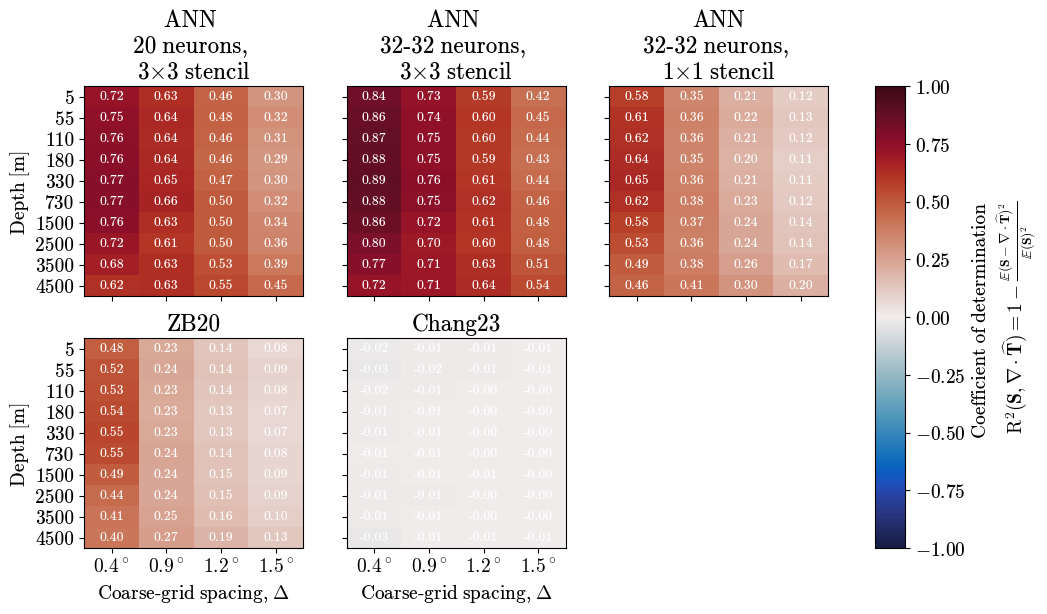

In [45]:
default_rcParams({'figure.subplot.wspace': 0.2, 'figure.subplot.hspace': 0.2, 'font.size':14})
fig = plt.figure(figsize=(12,6))

plt.subplot(2,3,1)
im_R2=plot_metric(ann_default, 'R2_away', ylabel=True, xlabel=False, add_cyan_rectangle=False, add_yellow_rectangle=False, add_orange_rectangle=False);
plt.title('ANN \n20 neurons, \n3$\\times$3 stencil')
plt.subplot(2,3,2)
im_R2=plot_metric(ann_32_32, 'R2_away', ylabel=False, xlabel=False, add_cyan_rectangle=False, add_yellow_rectangle=False, add_orange_rectangle=False);
plt.title('ANN \n32-32 neurons, \n3$\\times$3 stencil')
plt.subplot(2,3,3)
im_R2=plot_metric(ann_1x1, 'R2_away', ylabel=False, xlabel=False, add_cyan_rectangle=False, add_yellow_rectangle=False, add_orange_rectangle=False);
plt.title('ANN\n32-32 neurons, \n1$\\times$1 stencil')
plt.subplot(2,3,4)
im_R2=plot_metric(zb20, 'R2_away', ylabel=True, xlabel=True, add_cyan_rectangle=False, add_yellow_rectangle=False, add_orange_rectangle=False);
plt.title('ZB20')
plt.subplot(2,3,5)
im_R2=plot_metric(jansenheld, 'R2_away', ylabel=False, xlabel=True, add_cyan_rectangle=False, add_yellow_rectangle=False, add_orange_rectangle=False);
plt.title('Chang23')


axes = plt.gcf().axes
plt.colorbar(im_R2, ax=axes[0:5], 
             label='Coefficient of determination \n$\mathrm{R}^2(\\mathbf{S},\\nabla\\cdot\\widehat{\\mathbf{T}})=1-\\frac{\\mathbb{E}(\\mathbf{S}-\\nabla\\cdot\\widehat{\\mathbf{T}})^2}{\\mathbb{E}(\\mathbf{S})^2}$', aspect=15)

plt.savefig('figures/offline-metrics-sensitivity-extended.pdf', dpi=200)

# Online metrics given by timeseries

In [3]:
def time(x):
    x['Time'] = x['Time']-x['Time'].min()
    return x.sortby('Time')

control = time(xr.open_dataset('/scratch/pp2681/mom6/OM4_SIS2/unparameterized/output/ocean.stats.nc', decode_times=False))
series_default = time(xr.open_dataset('/scratch/pp2681/mom6/OM4_SIS2/ANN-greenline/output/ocean.stats.nc', decode_times=False))
series_32_32 = time(xr.open_dataset('/scratch/pp2681/mom6/OM4_SIS2/ANN-3x3-32-32/output/ocean.stats.nc', decode_times=False))
series_1x1 = time(xr.open_dataset('/scratch/pp2681/mom6/OM4_SIS2/ANN-1x1/output/ocean.stats.nc', decode_times=False))

series_JH = time(xr.open_dataset('/scratch/pp2681/mom6/OM4_SIS2/JHAH15/output/ocean.stats.nc', decode_times=False))
series_zb20 = time(xr.open_dataset('/scratch/pp2681/mom6/OM4_SIS2/ZB20-Klower/output/ocean.stats.nc', decode_times=False))

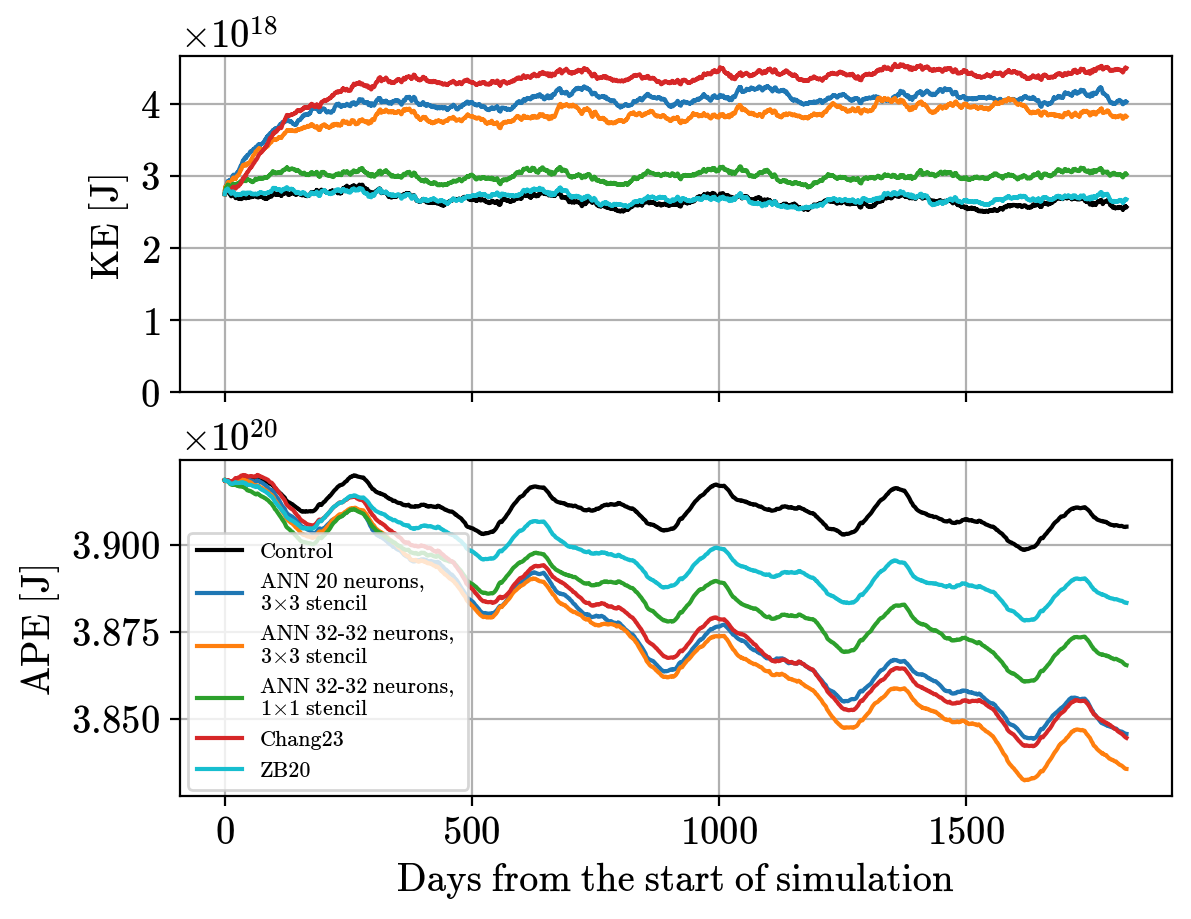

In [15]:
default_rcParams({'figure.subplot.wspace': 0.2, 'figure.subplot.hspace': 0.2, 'font.size':14})
plt.figure(dpi=200)
plt.subplot(2,1,1)
time(control).KE.sum('Layer').plot(color='k', label='Control')
time(series_default).KE.sum('Layer').plot(label='ANN 20 neurons, \n3$\\times$3 stencil')
time(series_32_32).KE.sum('Layer').plot(label='ANN 32-32 neurons, \n3$\\times$3 stencil')
time(series_1x1).KE.sum('Layer').plot(label='ANN 32-32 neurons, \n1$\\times$1 stencil')
time(series_JH).KE.sum('Layer').plot(label='Chang23')
time(series_zb20).KE.sum('Layer').plot(label='ZB20', color='tab:cyan')
plt.xlabel('')
plt.xticks([0,500,1000,1500], []*4)
plt.ylabel('KE [J]')
plt.ylim([0,None])
plt.yticks([0, 1e+18, 2e+18, 3e+18, 4e+18])
plt.grid()

plt.subplot(2,1,2)
time(control).APE.sum('Interface').plot(color='k', label='Control')
time(series_default).APE.sum('Interface').plot(label='ANN 20 neurons, \n3$\\times$3 stencil')
time(series_32_32).APE.sum('Interface').plot(label='ANN 32-32 neurons, \n3$\\times$3 stencil')
series_1x1.APE.sum('Interface').plot(label='ANN 32-32 neurons, \n1$\\times$1 stencil')
time(series_JH).APE.sum('Interface').plot(label='Chang23')
time(series_zb20).APE.sum('Interface').plot(label='ZB20', color='tab:cyan')
plt.ylabel('APE [J]')
plt.legend(bbox_to_anchor=(0.15,0.4), loc='center', fontsize=8)
plt.xlabel('Days from the start of simulation')
plt.grid()

plt.savefig('figures/online-metrics-sensitivity-extended.pdf')